# Pre-Processing

In [1]:
# requiried packages
import splitfolders
import shutil
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
from urllib.parse import urlparse
import scipy
from PIL import Image, ImageFile
from skimage.util import img_as_ubyte
from tqdm import tqdm
from pathlib import Path
import tifffile
import random
from collections import defaultdict

## 1. Compose multi-channel images from single channel images (Stacking channels)

In [8]:
def stack_images(base, root, out_dir):
    imgs = []
    for c in ['c1', 'c2', 'c3', 'c4']:
        directory = os.path.join(root, c)
        img = os.path.join(directory, base + c + ".tif")
        imgs.append(img)

    # Open the TIFF images
    c1 = Image.open(imgs[0])
    c2 = Image.open(imgs[1])
    c3 = Image.open(imgs[2])
    c4 = Image.open(imgs[3])
    
    # Convert to NumPy array
    c1_array = np.array(c1)
    c2_array = np.array(c2)
    c3_array = np.array(c3)
    c4_array = np.array(c4)
    
    # Check dimensions match
    if not (c1_array.shape == c2_array.shape == c3_array.shape == c4_array.shape):
        raise ValueError("All images must have the same dimensions")

    # Stack the arrays along a new axis (channel dimension) (H, W) -> (H, W, C)
    stacked_array = np.stack([c1_array, c2_array, c3_array, c4_array], axis=-1)

    # Save the stacked array as an TIFF image in out_dir
    output_path = os.path.join(out_dir, base + ".tif")
    tifffile.imwrite(output_path, stacked_array)

    return output_path


def make_stacked_images(input_dir, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    for root, dirs, files in os.walk(input_dir):
        if len(dirs) == 4: # if dirs are c1, c2, c3, c4
            # images path 
            images = [img for img in os.listdir(os.path.join(root, dirs[0])) if ".tif" in img and img[0] != "."]
            for img in images:
                base = img.split(".")[0]
                basename = base[:-2]
                # method to stack images and save them in output dir
                stack_images(basename, root, out_dir)

### Stacking Mutants

In [13]:
in_dir = '/scratch/leuven/359/vsc35907/feature_extraction_data/raw_data/M9Lala mutants/'   
out_dir = '/scratch/leuven/359/vsc35907/feature_extraction_data/stacked_images/mutants/'    

make_stacked_images(in_dir, out_dir)

### Stacking Wild Types

In [14]:
in_dir = '/scratch/leuven/359/vsc35907/feature_extraction_data/raw_data/M9Lala WTs/'   
out_dir = '/scratch/leuven/359/vsc35907/feature_extraction_data/stacked_images/wild_type/'    

make_stacked_images(in_dir, out_dir)

## 2. Omnipose segmentation of our stacked images

To segment your stacked images based on the phase constrast channel, run the following in the command line:


__Mutant Group:__

```
omnipose --dir '/scratch/leuven/359/vsc35907/feature_extraction_data/stacked_images/mutants/' \
    --use_gpu --pretrained_model 'bact_phase_omni' \
    --save_tif --savedir '/scratch/leuven/359/vsc35907/feature_extraction_data/stacked_images/mutants/masks' \
    --chan 1 --nchan 2 --dim 2 --nclasses 3  \
    --no_npy --mask_threshold 0
```

__Wild Type Group:__

```
omnipose --dir '/scratch/leuven/359/vsc35907/feature_extraction_data/stacked_images/wild_type/' \
    --pretrained_model 'bact_phase_omni' \
    --save_tif --savedir '/scratch/leuven/359/vsc35907/feature_extraction_data/stacked_images/wild_type/masks' \
    --chan 1 --nchan 2 --dim 2 --nclasses 3  \
    --no_npy --mask_threshold 0
```

__PS:__

We set __--chan 1__ so that we use the phase constrast channel for our segmentation (in your images it might be different channel!). 

Remember to change the paths to where your images are and where you wanna save them!

Also, remove --use_gpu if you don't have a GPU!

### Visualization of one example image

In [30]:
import matplotlib.pyplot as plt

def display_result(img_pred, img):
    # Open the images
    results = Image.open(img_pred)
    original = Image.open(img)

    # Convert the images to numpy arrays
    array_results = np.array(results)
    array_original = np.array(original)

    # Normalize the image to 0-255 for display
    img_array_normalized_pred = (array_results / array_results.max()) * 255
    img_array_normalized_og = (array_original / array_original.max()) * 255

    # Convert to uint8 for display
    img_array_normalized_pred = img_array_normalized_pred.astype(np.uint8)
    img_array_normalized_og = img_array_normalized_og.astype(np.uint8)

    # Plot both images side by side
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Mask")
    plt.imshow(img_array_normalized_pred[500:1000,500:1000], cmap='grey')

    plt.subplot(1, 2, 2)
    plt.title("Phase-Contrast Channel")
    plt.imshow(array_original[500:1000,500:1000,0], cmap='gray')
    plt.show()


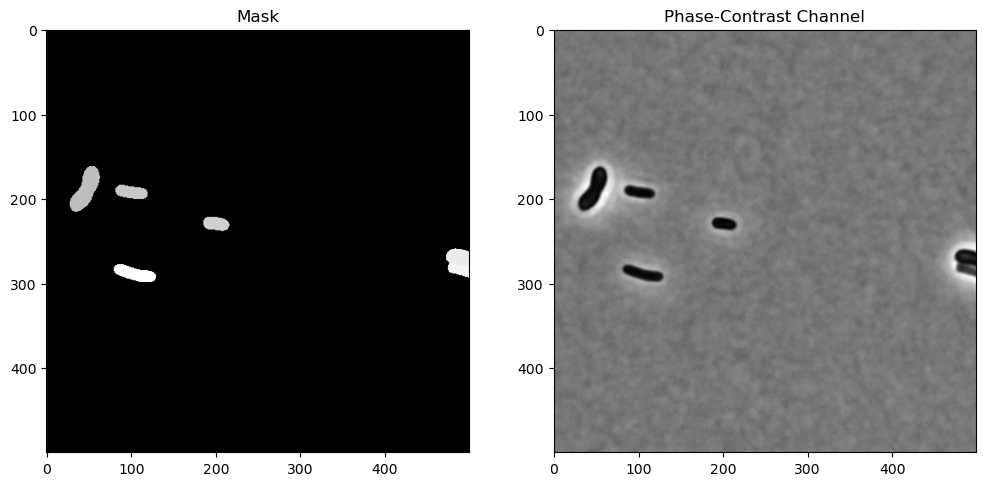

In [31]:
# Images Path:
img_mask = '/scratch/leuven/359/vsc35907/feature_extraction_data/stacked_images/mutants/masks/190425-mg aczv p1 002 m9lalaxy20_cp_masks.tif'
img = '/scratch/leuven/359/vsc35907/feature_extraction_data/stacked_images/mutants/190425-mg aczv p1 002 m9lalaxy20.tif'

# Display Images:
display_result(img_mask, img)

In [50]:
#print(plt.colormaps())

### Generate patches

Run the following script in the command line for both your __mutant__ and __wild-type__ stacked images:
```
python src/patch_generator4.0.py \
--input-dir '/scratch/leuven/359/vsc35907/feature_extraction_data/stacked_images/mutants/' \
--output-dir '/scratch/leuven/359/vsc35907/feature_extraction_data/patches8/mutants/' 
```

Adjust the --batch-size (defaul 100) depending on your available RAM. 

Alternatively, you can run the cells bellow.

__PS:__ is a LOT FASTER to run the script. I optimized as much as i could ; )

__NOTE:__ My dataset was pretty big and saved in a HDD. Saving all the patches in two folders (mutants and wild_type) was not ideal. This is because as the folder grows it gets harder and harder to update its file referrence system thus the time to process increases kinda linear and we have a lot of patches. For a future me or someone else: save the patches in many subfolders to make your life easier.

In [14]:
def patch_generator(image, mask_file, output_dir, patch_size=75, background=False):
    
    # Create outputdir if it does not already exist
    os.makedirs(output_dir, exist_ok=True) 
    
    # Retrieve Basename
    basename = os.path.basename(image)
    base = basename.split(".")[0]  # Get filename without extension
    
    # Load our labeled mask & our Stacked Image
    mask_image = Image.open(mask_file)
    mask = np.array(mask_image)
    img_array = tifffile.imread(image)
    
    # Get unique labels (excluding 0, which is background)
    unique_labels = np.unique(mask)
    unique_labels = unique_labels[unique_labels != 0]

    # Define patch size (e.g., 75x75 pixels)
    patch_size = patch_size + 1
    half_size = patch_size // 2

    # Image dimensions
    image_height, image_width = mask.shape
    
    total_patches = 0
    total_skipped = 0
    # Process each cell in the Mask
    for label in unique_labels:
        # Create a binary mask for the current cell
        cell_mask = (mask == label).astype(np.uint8)

        # CENTROID OF CELL:
        moments = cv2.moments(cell_mask)
        if moments["m00"] != 0:  # Ensure the cell has non-zero area
            center_x = int(moments["m10"] / moments["m00"])
            center_y = int(moments["m01"] / moments["m00"])
        else:
            # print(f"Skipped label {label}: No pixels found.")
            total_skipped += 1
            continue  # Skip if the cell is invalid

        # IMAGE BOUNDARIES:
        top_left_x = center_x - half_size
        top_left_y = center_y - half_size
        bottom_right_x = center_x + half_size
        bottom_right_y = center_y + half_size

        # Check if the full patch fits within the image
        if (top_left_x < 0 or 
            top_left_y < 0 or 
            bottom_right_x > image_width or 
            bottom_right_y > image_height):
            # print(f"Skipped label {label}: Patch exceeds image boundaries.")
            total_skipped += 1
            continue  # Skip if the patch would go outside the image

        # Extract the patch from the image and make a deep copy
        patch = np.copy(img_array[top_left_y:bottom_right_y, top_left_x:bottom_right_x])

        if not background:
            # Set background to zero (where mask != current label) on the copied patch
            patch_mask = mask[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
            patch[patch_mask != label] = 0

        # Save the patch
        output_path = os.path.join(output_dir, f"{base}_{label}.tif")
        tifffile.imwrite(output_path, patch)
        total_patches += 1

    print(f"Image: {basename} generated {total_patches} patches. {total_skipped} cells were skipped out of {len(unique_labels)} cells")
    return total_patches

### Generating patches for the mutants

In [ ]:
stacked_imgs = '/scratch/leuven/359/vsc35907/feature_extraction_data/stacked_images/mutants/'
outdir = '/scratch/leuven/359/vsc35907/feature_extraction_data/patches7/mutants/'

for file in [f for f in os.listdir(stacked_imgs) if ".tif" in f]:
    base = file.split(".")[0]
    mask = base + "_cp_masks.tif"
    patch_generator(os.path.join(stacked_imgs, file), os.path.join(stacked_imgs, "masks", mask), outdir, patch_size=75, background=False)

### Generating patches for the wild type

In [ ]:
stacked_imgs = '/scratch/leuven/359/vsc35907/feature_extraction_data/stacked_images/wild_type/'
outdir = '/scratch/leuven/359/vsc35907/feature_extraction_data/patches7/wild_type/'

for file in [f for f in os.listdir(stacked_imgs) if ".tif" in f]:
    base = file.split(".")[0]
    mask = base + "_cp_masks.tif"
    patch_generator(os.path.join(stacked_imgs, file), os.path.join(stacked_imgs, "masks", mask), outdir, patch_size=75, background=False)

## 3. Create balanced train/validation/test sets

- Ensures ~ 50/50% class balance (wild-type and mutant)
- Ensures there are no images from the same batch in each of the sets (train/val/test) for the wild type.
- Ensures there are no images from the same mutant group (total 800 mutants) in each of the sets (train/val/test) for the mutants.

In [2]:
import os
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Define the dataset path (update this to your actual path)
DATASET_PATH = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs'

# Your helper functions
def get_batch_number(filename):
    """Extract batch number from wild-type filename."""
    basename = os.path.basename(filename)
    parts = basename.split(' ')
    first_part = parts[0]
    batch_number = first_part.split('-')[0]
    if not batch_number.isdigit():
        raise ValueError(f"Invalid batch number in filename: {filename}")
    return batch_number

def get_mutant_number(filename):
    """Extract mutant number from mutant filename."""
    basename = os.path.basename(filename)
    parts = basename.split(' ')
    if len(parts) < 4:
        raise ValueError(f"Filename does not have enough parts: {filename}")
    elif len(parts) == 4:
        mutant_number = parts[2]
    elif len(parts) == 5:
        mutant_number = parts[3]
    else:
        raise ValueError(f"Invalid mutant number in filename: {filename}")
    if not mutant_number.isdigit():
        raise ValueError(f"Invalid mutant number in filename: {filename}")
    return mutant_number

In [3]:
# Step 1: Collect all image files
wild_type_files = []
for root, dirs, files in os.walk(os.path.join(DATASET_PATH, 'wild_type')):
    for file in files:
        if file.endswith('.tif'):
            wild_type_files.append(os.path.join(root, file))

mutant_files = []
for root, dirs, files in os.walk(os.path.join(DATASET_PATH, 'mutants')):
    for file in files:
        if file.endswith('.tif'):
            mutant_files.append(os.path.join(root, file))

# Step 2: Group files by batch or mutant number
wild_type_groups = defaultdict(list)
for file in wild_type_files:
    batch = get_batch_number(file)
    wild_type_groups[batch].append(file)

mutant_groups = defaultdict(list)
for file in mutant_files:
    mutant = get_mutant_number(file)
    mutant_groups[mutant].append(file)

# Step 3: Calculate image counts per group and total
wild_type_group_counts = {batch: len(files) for batch, files in wild_type_groups.items()}
mutant_group_counts = {mutant: len(files) for mutant, files in mutant_groups.items()}
total_wild_type_images = sum(wild_type_group_counts.values())
total_mutant_images = sum(mutant_group_counts.values())

# Step 4: Balance the classes by selecting groups
target_images_per_class = min(total_wild_type_images, total_mutant_images)
sorted_wild_type_groups = sorted(wild_type_group_counts.items(), key=lambda x: x[1], reverse=True)
sorted_mutant_groups = sorted(mutant_group_counts.items(), key=lambda x: x[1], reverse=True)

selected_wild_type_batches = []
wild_type_image_count = 0
for batch, count in sorted_wild_type_groups:
    if wild_type_image_count + count <= target_images_per_class:
        selected_wild_type_batches.append(batch)
        wild_type_image_count += count
    else:
        break

selected_mutant_groups = []
mutant_image_count = 0
for mutant, count in sorted_mutant_groups:
    if mutant_image_count + count <= target_images_per_class:
        selected_mutant_groups.append(mutant)
        mutant_image_count += count
    else:
        break

# Step 5: Split groups into train, validation, and test sets
train_wt_batches, temp_wt_batches = train_test_split(selected_wild_type_batches, test_size=0.3, random_state=42)
val_wt_batches, test_wt_batches = train_test_split(temp_wt_batches, test_size=0.5, random_state=42)

train_mut_groups, temp_mut_groups = train_test_split(selected_mutant_groups, test_size=0.3, random_state=42)
val_mut_groups, test_mut_groups = train_test_split(temp_mut_groups, test_size=0.5, random_state=42)

# Step 6: Collect files for each dataset split
train_files = [file for batch in train_wt_batches for file in wild_type_groups[batch]] + \
              [file for mutant in train_mut_groups for file in mutant_groups[mutant]]
val_files = [file for batch in val_wt_batches for file in wild_type_groups[batch]] + \
            [file for mutant in val_mut_groups for file in mutant_groups[mutant]]
test_files = [file for batch in test_wt_batches for file in wild_type_groups[batch]] + \
             [file for mutant in test_mut_groups for file in mutant_groups[mutant]]

# Step 7: Separate files by class for each split
train_wt_files = [file for batch in train_wt_batches for file in wild_type_groups[batch]]
train_mut_files = [file for mutant in train_mut_groups for file in mutant_groups[mutant]]
val_wt_files = [file for batch in val_wt_batches for file in wild_type_groups[batch]]
val_mut_files = [file for mutant in val_mut_groups for file in mutant_groups[mutant]]
test_wt_files = [file for batch in test_wt_batches for file in wild_type_groups[batch]]
test_mut_files = [file for mutant in test_mut_groups for file in mutant_groups[mutant]]

### Print Summary information

In [4]:
# Step 8: Calculate summary information
train_wild_type_count = sum(len(wild_type_groups[batch]) for batch in train_wt_batches)
train_mutant_count = sum(len(mutant_groups[mutant]) for mutant in train_mut_groups)
val_wild_type_count = sum(len(wild_type_groups[batch]) for batch in val_wt_batches)
val_mutant_count = sum(len(mutant_groups[mutant]) for mutant in val_mut_groups)
test_wild_type_count = sum(len(wild_type_groups[batch]) for batch in test_wt_batches)
test_mutant_count = sum(len(mutant_groups[mutant]) for mutant in test_mut_groups)

# Calculate total images across all sets
total_images = wild_type_image_count + mutant_image_count

# Calculate total images per set
train_total = train_wild_type_count + train_mutant_count
val_total = val_wild_type_count + val_mutant_count
test_total = test_wild_type_count + test_mutant_count

# Calculate percentages within each set
train_wild_type_pct = (train_wild_type_count / train_total * 100) if train_total > 0 else 0
train_mutant_pct = (train_mutant_count / train_total * 100) if train_total > 0 else 0
val_wild_type_pct = (val_wild_type_count / val_total * 100) if val_total > 0 else 0
val_mutant_pct = (val_mutant_count / val_total * 100) if val_total > 0 else 0
test_wild_type_pct = (test_wild_type_count / test_total * 100) if test_total > 0 else 0
test_mutant_pct = (test_mutant_count / test_total * 100) if test_total > 0 else 0

# Calculate percentage of each set relative to total images
train_set_pct = (train_total / total_images * 100) if total_images > 0 else 0
val_set_pct = (val_total / total_images * 100) if total_images > 0 else 0
test_set_pct = (test_total / total_images * 100) if total_images > 0 else 0

# Print summary
print(f"Total wild-type images selected: {wild_type_image_count}")
print(f"Total mutant images selected: {mutant_image_count}")
print(f"\nNumber of wild-type batches: {len(selected_wild_type_batches)}")
print(f"Number of mutant groups: {len(selected_mutant_groups)}")
print(f"\nTrain ({train_set_pct:.2f}% of total):")
print(f" - {len(train_wt_batches)} wild-type batches, {train_wild_type_count} wild-type images ({train_wild_type_pct:.2f}% of train)")
print(f" - {len(train_mut_groups)} mutant groups, {train_mutant_count} mutant images ({train_mutant_pct:.2f}% of train)")
print(f"Validation ({val_set_pct:.2f}% of total):")
print(f" - {len(val_wt_batches)} wild-type batches, {val_wild_type_count} wild-type images ({val_wild_type_pct:.2f}% of val)")
print(f" - {len(val_mut_groups)} mutant groups, {val_mutant_count} mutant images ({val_mutant_pct:.2f}% of val)")
print(f"Test ({test_set_pct:.2f}% of total):")
print(f" - {len(test_wt_batches)} wild-type batches, {test_wild_type_count} wild-type images ({test_wild_type_pct:.2f}% of test)")
print(f" - {len(test_mut_groups)} mutant groups, {test_mutant_count} mutant images ({test_mutant_pct:.2f}% of test)")

Total wild-type images selected: 405493
Total mutant images selected: 408765

Number of wild-type batches: 8
Number of mutant groups: 107

Train (65.04% of total):
 - 5 wild-type batches, 249378 wild-type images (47.09% of train)
 - 74 mutant groups, 280182 mutant images (52.91% of train)
Validation (14.56% of total):
 - 1 wild-type batches, 54005 wild-type images (45.55% of val)
 - 16 mutant groups, 64553 mutant images (54.45% of val)
Test (20.40% of total):
 - 2 wild-type batches, 102110 wild-type images (61.46% of test)
 - 17 mutant groups, 64030 mutant images (38.54% of test)


In [6]:
from tqdm import tqdm

# Step 9: Organize files into directories with symlinks
def organize_files(file_list, split, class_name, images_per_subdir=5000, base_dir="/scratch/leuven/359/vsc35907/big_data_feature_extraction/dataset"):
    class_dir = os.path.join(base_dir, split, class_name)
    os.makedirs(class_dir, exist_ok=True)
    num_subdirs = (len(file_list) + images_per_subdir - 1) // images_per_subdir
    for i in range(num_subdirs):
        subdir = os.path.join(class_dir, f'subdir_{i+1}')
        os.makedirs(subdir, exist_ok=True)
        #print(subdir)
    # Add progress bar for symlink creation
    desc = f"Organizing {split}/{class_name} ({len(file_list)} images)"
    for i, file in enumerate(tqdm(file_list, desc=desc, unit="image")):
        subdir_index = i // images_per_subdir
        subdir = os.path.join(class_dir, f'subdir_{subdir_index+1}')
        symlink_path = os.path.join(subdir, os.path.basename(file))
        if not os.path.exists(symlink_path):
            os.symlink(file, symlink_path)

# Organize the files
organize_files(train_wt_files, "train", "wild_type")
organize_files(train_mut_files, "train", "mutants")
organize_files(val_wt_files, "val", "wild_type")
organize_files(val_mut_files, "val", "mutants")
organize_files(test_wt_files, "test", "wild_type")
organize_files(test_mut_files, "test", "mutants")

Organizing test/mutants (64030 images): 100%|██████████| 64030/64030 [00:10<00:00, 6375.29image/s]


# Next Steps:
## Training 

```
python ./src/train.py \
    --data-dir '/scratch/leuven/359/vsc35907/feature_extraction_data/data/' \
    --output-dir '/data/leuven/359/vsc35907/EfficientNet_feature_extraction/outputs' \
    --save-name 'model_patches3_lr_3e4_rmsprop_wd_1e3' \
    --epochs 200 \
    --optimizer 'RMSprop' \
    --learning-rate 3e-4 \
    --weight-decay 1e-3 \
    --patience 15
```
## Feature Extraction
```
python ./src/feature_extraction.py \
    --model-path '/data/leuven/359/vsc35907/EfficientNet_feature_extraction/outputs/model_patches3_lr_3e4_rmsprop_wd_1e3.pth' \
    --dataset-path '/scratch/leuven/359/vsc35907/feature_extraction_data/patches3/' \
    --output-path '/scratch/leuven/359/vsc35907/feature_extraction_data/patches3/patches3_rmsprop_features.csv'
```

## Data Analysis

Check out: __src/data_analysis__ folder

# ------------------------------- *The End* --------------------------------

In [ ]:
import os
import glob
from collections import defaultdict
from sklearn.model_selection import train_test_split

def get_batch_number(filename):
    """Extract batch number from wild-type filename."""
    basename = os.path.basename(filename)
    parts = basename.split(' ')
    first_part = parts[0]
    batch_number = first_part.split('-')[0]
    if not batch_number.isdigit():
        raise ValueError(f"Invalid batch number in filename: {filename}")
    return batch_number

def get_mutant_number(filename):
    """Extract mutant number from mutant filename."""
    basename = os.path.basename(filename)
    parts = basename.split(' ')
    if len(parts) < 4:
        raise ValueError(f"Filename does not have enough parts: {filename}")
    mutant_number = parts[3]
    if not mutant_number.isdigit():
        raise ValueError(f"Invalid mutant number in filename: {filename}")
    return mutant_number

In [ ]:
# List all TIFF files in the subfolders
wild_type_files = glob.glob("patches/wild_type/*.tif")
mutant_files = glob.glob("patches/mutants/*.tif")

# Group wild-type files by batch number and count images
wild_type_groups = defaultdict(list)
for file in wild_type_files:
    batch = get_batch_number(file)
    wild_type_groups[batch].append(file)

# Group mutant files by mutant number and count images
mutant_groups = defaultdict(list)
for file in mutant_files:
    mutant = get_mutant_number(file)
    mutant_groups[mutant].append(file)

# Calculate total images per group
wild_type_batch_counts = {batch: len(files) for batch, files in wild_type_groups.items()}
mutant_group_counts = {mutant: len(files) for mutant, files in mutant_groups.items()}

# Get total image counts
total_wild_type_images = sum(wild_type_batch_counts.values())
total_mutant_images = sum(mutant_group_counts.values())

# Determine the target number of images for balancing (use the smaller class)
target_images_per_class = min(total_wild_type_images, total_mutant_images)

# Sort groups by image count to facilitate balanced selection
sorted_wild_type_batches = sorted(wild_type_batch_counts.items(), key=lambda x: x[1], reverse=True)
sorted_mutant_groups = sorted(mutant_group_counts.items(), key=lambda x: x[1], reverse=True)

# Select batches to match target_images_per_class
selected_wild_type_batches = []
wild_type_image_count = 0
for batch, count in sorted_wild_type_batches:
    if wild_type_image_count + count <= target_images_per_class:
        selected_wild_type_batches.append(batch)
        wild_type_image_count += count
    else:
        break

# Select mutant groups to match target_images_per_class
selected_mutant_groups = []
mutant_image_count = 0
for mutant, count in sorted_mutant_groups:
    if mutant_image_count + count <= target_images_per_class:
        selected_mutant_groups.append(mutant)
        mutant_image_count += count
    else:
        break

# Split selected wild-type batches into train (70%), temp (30%), then temp into val (15%) and test (15%)
train_batches, temp_batches = train_test_split(selected_wild_type_batches, test_size=0.3, random_state=42)
val_batches, test_batches = train_test_split(temp_batches, test_size=0.5, random_state=42)

# Split selected mutant groups similarly
train_mutants, temp_mutants = train_test_split(selected_mutant_groups, test_size=0.3, random_state=42)
val_mutants, test_mutants = train_test_split(temp_mutants, test_size=0.5, random_state=42)

# Collect files for each set
train_files = [file for batch in train_batches for file in wild_type_groups[batch]] + \
              [file for mutant in train_mutants for file in mutant_groups[mutant]]
val_files = [file for batch in val_batches for file in wild_type_groups[batch]] + \
            [file for mutant in val_mutants for file in mutant_groups[mutant]]
test_files = [file for batch in test_batches for file in wild_type_groups[batch]] + \
             [file for mutant in test_mutants for file in mutant_groups[mutant]]

#### Print summary for verification

In [ ]:
train_wild_type_count = sum(len(wild_type_groups[batch]) for batch in train_batches)
train_mutant_count = sum(len(mutant_groups[mutant]) for mutant in train_mutants)
val_wild_type_count = sum(len(wild_type_groups[batch]) for batch in val_batches)
val_mutant_count = sum(len(mutant_groups[mutant]) for mutant in val_mutants)
test_wild_type_count = sum(len(wild_type_groups[batch]) for batch in test_batches)
test_mutant_count = sum(len(mutant_groups[mutant]) for mutant in test_mutants)

# Calculate total images across all sets
total_images = wild_type_image_count + mutant_image_count

# Calculate total images per set
train_total = train_wild_type_count + train_mutant_count
val_total = val_wild_type_count + val_mutant_count
test_total = test_wild_type_count + test_mutant_count

# Calculate percentages within each set
train_wild_type_pct = (train_wild_type_count / train_total * 100) if train_total > 0 else 0
train_mutant_pct = (train_mutant_count / train_total * 100) if train_total > 0 else 0
val_wild_type_pct = (val_wild_type_count / val_total * 100) if val_total > 0 else 0
val_mutant_pct = (val_mutant_count / val_total * 100) if val_total > 0 else 0
test_wild_type_pct = (test_wild_type_count / test_total * 100) if test_total > 0 else 0
test_mutant_pct = (test_mutant_count / test_total * 100) if test_total > 0 else 0

# Calculate percentage of each set relative to total images
train_set_pct = (train_total / total_images * 100) if total_images > 0 else 0
val_set_pct = (val_total / total_images * 100) if total_images > 0 else 0
test_set_pct = (test_total / total_images * 100) if total_images > 0 else 0

print(f"Total wild-type images selected: {wild_type_image_count}")
print(f"Total mutant images selected: {mutant_image_count}")
print(f"\nNumber of wild-type batches: {len(selected_wild_type_batches)}")
print(f"Number of mutant groups: {len(selected_mutant_groups)}")
print(f"\nTrain ({train_set_pct:.2f}% of total):\n - {len(train_batches)} wild-type batches, {train_wild_type_count} wild-type images ({train_wild_type_pct:.2f}% of train)\n - {len(train_mutants)} mutant groups, "
      f"{train_mutant_count} mutant images ({train_mutant_pct:.2f}% of train)")
print(f"Validation ({val_set_pct:.2f}% of total):\n - {len(val_batches)} wild-type batches, {val_wild_type_count} wild-type images ({val_wild_type_pct:.2f}% of val)\n - {len(val_mutants)} mutant groups, "
      f"{val_mutant_count} mutant images ({val_mutant_pct:.2f}% of val)")
print(f"Test ({test_set_pct:.2f}% of total):\n - {len(test_batches)} wild-type batches, {test_wild_type_count} wild-type images ({test_wild_type_pct:.2f}% of test)\n - {len(test_mutants)} mutant groups, "
      f"{test_mutant_count} mutant images ({test_mutant_pct:.2f}% of test)")

#### Copies files into (train/val/test) to your specified data directory  

In [ ]:
import os
import shutil
import time
from tqdm import tqdm
import logging
import psutil

# Set up logging
logging.basicConfig(
    filename="file_copy_log.txt",
    level=logging.INFO,
    format="%( asctime)s - %(levelname)s - %(message)s"
)

# Check available disk space (in bytes)
def check_disk_space(path):
    disk = psutil.disk_usage(path)
    free_space = disk.free
    return free_space

# Copy files in batches with error handling and logging
def copy_files_with_progress(files, dest_base, set_name, batch_size=100):
    total_files = len(files)
    logging.info(f"Starting to copy {total_files} {set_name} files")
    print(f"Copying {set_name} files...")

    # Check available disk space
    free_space = check_disk_space(dest_base)
    estimated_size_per_file = 49 * 1024  # 49KB per file
    if free_space < total_files * estimated_size_per_file:
        logging.error(f"Insufficient disk space for {set_name}. Free: {free_space / (1024**3):.2f} GB")
        raise RuntimeError(f"Insufficient disk space for {set_name} files")

    # Calculate number of batches
    num_batches = (total_files + batch_size - 1) // batch_size

    # Process files in batches with progress bar on batches
    for i in tqdm(range(0, total_files, batch_size), total=num_batches, desc=f"{set_name} Batches"):
        batch = files[i:i + batch_size]
        for file in batch:
            try:
                if not os.path.exists(file):
                    logging.warning(f"File not found: {file}")
                    continue
                if "wild_type" in file:
                    dest = os.path.join(dest_base, f"{set_name}/wild_type", os.path.basename(file))
                else:
                    dest = os.path.join(dest_base, f"{set_name}/mutants", os.path.basename(file))
                shutil.copy2(file, dest)  # Use copy2 to preserve metadata
                logging.info(f"Copied: {file} to {dest}")
            except (IOError, OSError) as e:
                logging.error(f"Error copying {file}: {str(e)}")
                print(f"Error copying {file}: {str(e)}")
                continue
        # Brief pause to reduce system load
        time.sleep(0.1)

    logging.info(f"Completed copying {set_name} files")

# Create output directories with wild_type and mutants subfolders
output_dir = "/media/theo/BS4/M9Lala feature extraction data/dataset_split"
try:
    os.makedirs(os.path.join(output_dir, "train/wild_type"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "train/mutants"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "val/wild_type"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "val/mutants"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "test/wild_type"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "test/mutants"), exist_ok=True)
except OSError as e:
    logging.error(f"Error creating directories: {str(e)}")
    raise

# Copy files with progress bars and error handling
try:
    copy_files_with_progress(train_files, output_dir, "train", batch_size=100)
    copy_files_with_progress(val_files, output_dir, "val", batch_size=100)
    copy_files_with_progress(test_files, output_dir, "test", batch_size=100)
except Exception as e:
    logging.error(f"Unexpected error during file copying: {str(e)}")
    print(f"Unexpected error: {str(e)}")

### Downsample the mutant images if data is largely imbalanced

In [26]:
import os

wild_type = '/scratch/leuven/359/vsc35907/feature_extraction_data/patches7/wild_type/'
mutants = '/scratch/leuven/359/vsc35907/feature_extraction_data/patches7/mutants/'
print(f'total patches (wild type): {len(os.listdir(wild_type))}')
print(f'total patches (mutants): {len(os.listdir(mutants))}')

total patches (wild type): 13300
total patches (mutants): 13300


In [23]:
groups_count = {}
for img in [ f for f in os.listdir(mutants) if ".tif" in f ]:
    group = img.split()[3]
    if group not in groups_count.keys():
        groups_count[group] = 1
    else:
        groups_count[group] += 1

print(f'Number of patches per mutant group:')
print(groups_count)

Number of patches per mutant group:
{'003': 3595, '005': 4809, '004': 2660, '001': 2681, '002': 3508}


In [29]:
import os
import random
from collections import defaultdict

def balance_dataset(wild_type_path, mutants_path):
    # Validate paths
    if not os.path.exists(wild_type_path) or not os.path.exists(mutants_path):
        raise FileNotFoundError("One or both directories do not exist")

    # Cache file lists
    mutant_files = [f for f in os.listdir(mutants_path) if f.endswith(".tif")]
    wt_files = [f for f in os.listdir(wild_type_path) if f.endswith(".tif")]
    print(f'Total patches (wild type): {len(wt_files)}')
    print(f'Total patches (mutants): {len(mutant_files)}')

    # Group mutants
    groups_count = defaultdict(int)
    groups_path = defaultdict(list)
    for img in mutant_files:
        try:
            group = img.split()[3]  # Adjust based on actual format
        except IndexError:
            print(f"Invalid filename format: {img}")
            continue
        groups_count[group] += 1
        groups_path[group].append(img)

    print(f'Number of patches per mutant group: {dict(groups_count)}')

    # Calculate balancing needs
    min_group = min(groups_count.values(), default=0)
    total_wt = len(wt_files)
    total_mt = len(mutant_files)
    estimate_size_mt = min_group * len(groups_count)
    real_diff = total_wt - total_mt
    # print(f'Min group size (mutants): {min_group}')
    # print(f'Estimated mutant size: {estimate_size_mt}')
    # print(f'Difference (wt - mt): {real_diff}')

    # Balance dataset
    if real_diff > 0:
        diff = total_wt - estimate_size_mt
        print(f'Need to remove {diff} wild type samples')
        files_to_remove = random.sample(wt_files, min(diff, len(wt_files)))
        for f in files_to_remove:
            try:
                os.remove(os.path.join(wild_type_path, f))
            except OSError as e:
                print(f"Failed to remove {f}: {e}")
        balance_dataset(wild_type_path, mutants_path)          
    elif real_diff < 0:
        for group, files in groups_path.items():
            if len(files) > min_group:
                files_to_remove = random.sample(files, len(files) - min_group)
                for f in files_to_remove:
                    try:
                        os.remove(os.path.join(mutants_path, f))
                    except OSError as e:
                        print(f"Failed to remove {f}: {e}")
        balance_dataset(wild_type_path, mutants_path)
    else:
        print()
        print('Perfect balance!')
        mutant_files = [f for f in os.listdir(mutants_path) if f.endswith(".tif")]
        wt_files = [f for f in os.listdir(wild_type_path) if f.endswith(".tif")]
        print(f'Total patches (wild type): {len(wt_files)}')
        print(f'Total patches (mutants): {len(mutant_files)}')


In [30]:
wild_type = '/scratch/leuven/359/vsc35907/feature_extraction_data/patches7/wild_type/'
mutants = '/scratch/leuven/359/vsc35907/feature_extraction_data/patches7/mutants/'
result = balance_dataset(wild_type, mutants)

Total patches (wild type): 13300
Total patches (mutants): 13300
Number of patches per mutant group: {'003': 2660, '005': 2660, '004': 2660, '001': 2660, '002': 2660}

Perfect balance!
Total patches (wild type): 13300
Total patches (mutants): 13300


In [5]:
# TODO: debugg!!!
def balance_dataset(wild_type_path, mutants_path):
    # Get mutant files once and reuse
    mutant_files = [f for f in os.listdir(mutants_path) if f.endswith(".tif")]
    print(f'total patches (mutants): {len(mutant_files)}')
    
    # Use defaultdict for automatic initialization
    groups_count = defaultdict(int)
    groups_path = defaultdict(list)
    
    # Single pass through mutant files for both counting and grouping
    for img in mutant_files:
        group = img.split()[3]  # Assumes group name is 4th element
        groups_count[group] += 1
        groups_path[group].append(img)

    print(f'Number of patches per mutant group:')
    print(dict(groups_count))  # Convert to regular dict for printing

    # Calculate totals and minimum samples
    min_group = min(groups_count.values())
    total_wt = len([f for f in os.listdir(wild_type_path) if f.endswith(".tif")])
    total_mt = len([f for f in os.listdir(mutants_path) if f.endswith(".tif")])
    estimate_size_mt = min_group * len(groups_path)
    real_diff = total_wt - total_mt
    diff = total_wt - estimate_size_mt
    print(f'min groups (mutants): {min_group}')
    print(f'total patches (wild type): {total_wt}')
    print(f'estimate_size_mt: {estimate_size_mt} ')
    print(f'Difference (wt - mt): {real_diff}')
    

    # Balance the dataset
    if real_diff > 0:
        print(f'Need to remove {diff} wild type samples to balance')
        wt_files = [f for f in os.listdir(wild_type_path) if f.endswith(".tif")]
        if wt_files:  # Check if there are files to remove
            files_to_remove = random.sample(wt_files, min(diff, len(wt_files)))
            for f in files_to_remove:
                os.remove(os.path.join(wild_type_path, f))
    elif real_diff < 0:
        
        diff = abs(diff)
        reduction_per_group = diff // len(groups_path)
        

        print(f'Reducing each mutant group by {reduction_per_group} to balance')
        for group, files in groups_path.items():
            if len(files) > min_group:
                excess = len(files) - (min_group)
                print(f"size group: {len(files)} excess: {excess}")
                files_to_remove = random.sample(files, min(excess, len(files)))
                for f in files_to_remove:
                    os.remove(os.path.join(mutants_path, f))
    else:
        print('Perfect balance')

### Check n of files in directories

In [18]:
groups_count = {}
for img in [ f for f in os.listdir(mutants) if ".tif" in f ]:
    group = img.split()[3]
    if group not in groups_count.keys():
        groups_count[group] = 1
    else:
        groups_count[group] += 1

print(f'Number of patches per mutant group:')
print(groups_count)
print(f'total patches (wild type): {len(os.listdir(wild_type))}')
print(f'total patches (mutants): {len(os.listdir(mutants))}')

Number of patches per mutant group:
{'003': 2660, '004': 2660, '001': 2660, '002': 2660, '005': 2660}
total patches (wild type): 13300
total patches (mutants): 13300
